In [1]:
!pip install yfinance

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque, namedtuple
import matplotlib.pyplot as plt
import yfinance as yf
import torch.nn.functional as F

# Global S&P 500 data
snp500_data = None

def fetch_snp500_data(start='2019-01-01', end='2023-12-31'):
    global snp500_data
    snp500_data = yf.download('^GSPC', start=start, end=end)
    print("S&P 500 data loaded.")

def get_close_prices():
    global snp500_data
    if snp500_data is not None:
        return snp500_data['Close'].values
    return None

class TradingEnv(gym.Env):
    def __init__(self, stock_prices, initial_cash=10000):
        super().__init__()
        self.stock_prices = stock_prices  # shape: (T, num_stocks)
        self.initial_cash = initial_cash
        self.num_stocks = stock_prices.shape[1]
        self.current_step = 0

        # Load S&P 500 data
        fetch_snp500_data()
        self.snp500_close_prices = get_close_prices()
        if self.snp500_close_prices is not None:
            # Align S&P 500 data with our stock data
            min_len = min(len(self.snp500_close_prices), len(stock_prices))
            self.snp500_close_prices = self.snp500_close_prices[:min_len]
            self.stock_prices = self.stock_prices[:min_len]
            
            # Normalize S&P 500 to match initial portfolio value
            self.snp500_normalized = (self.snp500_close_prices / self.snp500_close_prices[0]) * initial_cash
        else:
            # If no S&P 500 data, create array of initial cash value
            self.snp500_normalized = np.full(len(stock_prices), initial_cash)

        # Action: allocation vector (continuous values) that should sum to 1.
        self.action_space = gym.spaces.Box(low=0, high=1, shape=(self.num_stocks,), dtype=np.float32)
        # Observation: concatenation of current prices and current holdings.
        obs_low = np.zeros(self.num_stocks * 2, dtype=np.float32)
        obs_high = np.full(self.num_stocks * 2, np.inf, dtype=np.float32)
        self.observation_space = gym.spaces.Box(low=obs_low, high=obs_high, dtype=np.float32)

    def reset(self):
        self.current_step = 0
        current_prices = self.stock_prices[self.current_step]

        # Distribute initial cash equally among stocks
        allocation = np.full(self.num_stocks, 1.0 / self.num_stocks)
        self.cash = self.initial_cash
        self.holdings = (allocation * self.cash) / current_prices
        self.cash = 0.0  # All cash is used to buy stocks

        self.cost_basis = current_prices.copy()
        self.sold_profit = 0.0
        self.prev_portfolio_value = self.cash + np.sum(self.holdings * current_prices)

        # Store initial portfolio value for total return calculation
        self.initial_portfolio_value = self.prev_portfolio_value

        return np.concatenate([current_prices, self.holdings])
   
    def _get_obs(self):
        current_prices = self.stock_prices[self.current_step]
        return np.concatenate([current_prices, self.holdings])
   
    def step(self, action):
        current_prices = self.stock_prices[self.current_step]
        portfolio_value = self.cash + np.sum(self.holdings * current_prices)

        # Normalize action so that it sums to 1
        allocation = np.array(action) / np.sum(action)
        target_value = portfolio_value * allocation
        target_shares = target_value / current_prices

        # Rebalance portfolio while ensuring no negative holdings
        for i in range(self.num_stocks):
            delta = target_shares[i] - self.holdings[i]
            if delta < 0:  # Sell shares
                shares_to_sell = min(-delta, self.holdings[i])  # Prevent selling more than owned
                sale_amount = shares_to_sell * current_prices[i]
                realized_profit = (current_prices[i] - self.cost_basis[i]) * shares_to_sell
                self.holdings[i] -= shares_to_sell
                self.cash += sale_amount
                self.sold_profit += realized_profit
            elif delta > 0:  # Buy shares if cash available
                cost = delta * current_prices[i]
                if cost > self.cash:
                    delta = self.cash / current_prices[i]
                    cost = delta * current_prices[i]
                if self.holdings[i] > 0:
                    self.cost_basis[i] = ((self.cost_basis[i] * self.holdings[i]) + (current_prices[i] * delta)) / (self.holdings[i] + delta)
                else:
                    self.cost_basis[i] = current_prices[i]
                self.holdings[i] += delta
                self.cash -= cost

        # Compute new portfolio value
        next_portfolio_value = self.cash + np.sum(self.holdings * current_prices)

        # Calculate reward based on S&P 500 comparison
        if self.current_step > 0:
            reward = self.get_reward(next_portfolio_value, self.prev_portfolio_value)
        else:
            reward = 0

        self.prev_portfolio_value = next_portfolio_value
        self.current_step += 1
        done = self.current_step >= len(self.stock_prices)
        obs = self._get_obs() if not done else np.concatenate([self.stock_prices[-1], self.holdings])

        return obs, reward, done, {}

    def get_reward(self, next_portfolio_value, current_portfolio_value):
        # Reward is the change in portfolio value relative to S&P 500
        portfolio_growth = (next_portfolio_value - current_portfolio_value) / current_portfolio_value
        
        # Calculate S&P 500 growth for the same period
        if self.current_step < len(self.snp500_normalized) - 1:
            snp_growth = (self.snp500_normalized[self.current_step + 1] - self.snp500_normalized[self.current_step]) / self.snp500_normalized[self.current_step]
        else:
            snp_growth = 0
        
        # Reward is the difference between our growth and S&P 500 growth
        reward = portfolio_growth - snp_growth
        return reward

    def render(self, mode="human"):
        current_prices = self.stock_prices[self.current_step - 1]
        portfolio_value = self.cash + np.sum(self.holdings * current_prices)
        print(f"Day {self.current_step} - Portfolio Value: ${portfolio_value:.2f}, Cash: ${self.cash:.2f}")

    def get_portfolio_value(self):
        # Ensure current_step is within bounds
        if self.current_step < len(self.stock_prices):
            return self.cash + np.sum(self.holdings * self.stock_prices[self.current_step])
        else:
            return self.cash + np.sum(self.holdings * self.stock_prices[-1])  # Use last available prices
        
    def get_total_return(self):
        # Calculate the total return as the percentage change from the initial value
        final_portfolio_value = self.cash + np.sum(self.holdings * self.stock_prices[min(self.current_step, len(self.stock_prices) - 1)])
        total_return = (final_portfolio_value - self.initial_portfolio_value) / self.initial_portfolio_value * 100
        return total_return

    def plot_comparison(self, daily_values):
        """Plot portfolio value vs S&P 500 performance"""
        if len(daily_values) != len(self.snp500_normalized):
            print("Warning: Length mismatch between portfolio values and S&P 500 data")
            min_len = min(len(daily_values), len(self.snp500_normalized))
            daily_values = daily_values[:min_len]
            snp_values = self.snp500_normalized[:min_len]
        else:
            snp_values = self.snp500_normalized
        
        plt.figure(figsize=(12, 6))
        plt.plot(daily_values, label="Portfolio Value", color="blue")
        plt.plot(snp_values, label="S&P 500 (Normalized)", color="red", linestyle="--")
        plt.xlabel("Day")
        plt.ylabel("Value ($)")
        plt.title("Portfolio Performance vs S&P 500")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [10]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
   
    def push(self, *args):
        self.buffer.append(Transition(*args))
   
    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        return Transition(*zip(*transitions))
   
    def __len__(self):
        return len(self.buffer)

class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, action_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.softmax(self.fc3(x))

class CQLAgent:
    def __init__(self, state_dim, action_dim, device, gamma=0.99, tau=0.005, alpha=1.0, num_samples=10):
        self.device = device
        self.gamma = gamma
        self.tau = tau
        self.alpha = alpha
        self.num_samples = num_samples

        # Actor networks
        self.actor = Actor(state_dim, action_dim).to(device)
        self.actor_target = Actor(state_dim, action_dim).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=3e-4)

        # Critic networks
        self.critic = QNetwork(state_dim, action_dim).to(device)
        self.critic_target = QNetwork(state_dim, action_dim).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=3e-4)

    def select_action(self, state, epsilon=0.1):
        if np.random.random() < epsilon:
            return np.random.dirichlet(np.ones(self.actor.fc3.out_features))
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            action = self.actor(state).cpu().numpy()[0]
        return action

    def update(self, buffer, batch_size):
        if len(buffer) < batch_size:
            return None, None

        batch = buffer.sample(batch_size)

        # Convert to tensors with proper shape handling
        states = torch.FloatTensor(np.vstack(batch.state)).to(self.device)
        actions = torch.FloatTensor(np.vstack(batch.action)).to(self.device)

        # Handle rewards - convert to list first to handle scalar values
        rewards_list = [np.array(r, dtype=np.float32) for r in batch.reward]
        rewards = torch.FloatTensor(np.vstack(rewards_list)).unsqueeze(1).to(self.device)

        next_states = torch.FloatTensor(np.vstack(batch.next_state)).to(self.device)

        # Handle done flags - convert to list first to handle scalar values
        dones_list = [np.array(d, dtype=np.float32) for d in batch.done]
        dones = torch.FloatTensor(np.vstack(dones_list)).unsqueeze(1).to(self.device)

        # Critic update
        with torch.no_grad():
            next_actions = self.actor_target(next_states)
            next_Q = self.critic_target(next_states, next_actions)
            target_Q = rewards + (1 - dones) * self.gamma * next_Q

        current_Q = self.critic(states, actions)
        td_loss = F.mse_loss(current_Q, target_Q)

        # CQL regularization
        batch_size = states.size(0)
        action_dim = self.actor.fc3.out_features

        # Sample random actions using Dirichlet distribution
        sampled_actions = torch.distributions.Dirichlet(
            torch.ones(action_dim, device=self.device)
        ).sample((batch_size, self.num_samples))

        states_repeated = states.unsqueeze(1).repeat(1, self.num_samples, 1)
        states_repeated = states_repeated.view(batch_size * self.num_samples, -1)
        sampled_actions_flat = sampled_actions.view(-1, action_dim)

        # Compute Q-values for sampled actions
        sampled_Q = self.critic(states_repeated, sampled_actions_flat)
        sampled_Q = sampled_Q.view(batch_size, self.num_samples)

        # Combine with data Q-values
        data_Q = current_Q.detach()
        combined_Q = torch.cat([sampled_Q, data_Q], dim=1)
        cql_loss = torch.logsumexp(combined_Q, dim=1).mean() - data_Q.mean()

        # Total critic loss
        critic_loss = td_loss + self.alpha * cql_loss

        # Optimize critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic.parameters(), 1.0)
        self.critic_optimizer.step()

        # Actor update
        policy_actions = self.actor(states)
        actor_loss = -self.critic(states, policy_actions).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor.parameters(), 1.0)
        self.actor_optimizer.step()

        # Update target networks
        with torch.no_grad():
            for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
                target_param.data.mul_(1 - self.tau)
                target_param.data.add_(self.tau * param.data)

            for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
                target_param.data.mul_(1 - self.tau)
                target_param.data.add_(self.tau * param.data)

        return critic_loss.item(), actor_loss.item()

In [16]:
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

if __name__ == "__main__":
    # Configuration
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tickers = ["AAPL", "MSFT", "AMZN", "GOOGL", "META", "JPM", "JNJ", "V", "PG", "MA",
               "NVDA", "UNH", "HD", "DIS", "BAC", "PFE", "CMCSA", "VZ", "ADBE", "NFLX"]
    
    # Download data
    print("Downloading stock data...")
    data = yf.download(tickers, start="2019-01-01", end="2023-12-31")["Close"]
    data = data.fillna(method='ffill').fillna(method='bfill')
    stock_prices = data.values.astype(np.float32)
    
    # Create environment
    env = TradingEnv(stock_prices)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    
    # Initialize agent and replay buffer
    agent = CQLAgent(state_dim, action_dim, device, alpha=0.5, num_samples=10)
    replay_buffer = ReplayBuffer(100000)
    
    # Training parameters
    num_episodes = 200
    batch_size = 128
    min_epsilon = 0.01
    max_epsilon = 0.95

    # Training metrics
    rewards = []
    portfolio_values_per_episode = []
    last_episode_portfolio_values = []
    cumulative_returns = []
    step_count = 0
    decay_steps = 100
    decay_amount = (max_epsilon - min_epsilon) / decay_steps

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        episode_reward = 0.0  # Initialize as float
        episode_portfolio_values = []
        cumulative_return = 0.0

        # Decay epsilon
        epsilon = max(min_epsilon, max_epsilon - (step_count * decay_amount))
        step_count += 1

        while not done:
            action = agent.select_action(state, epsilon)
            next_state, reward, done, _ = env.step(action)
            replay_buffer.push(state, action, reward, next_state, done)
            state = next_state
            episode_reward += float(reward)  # Ensure reward is converted to float

            # Store portfolio value for each day
            episode_portfolio_values.append(env.get_portfolio_value())

            # Update agent
            agent.update(replay_buffer, batch_size)

        rewards.append(episode_reward)
        portfolio_values_per_episode.append(env.get_portfolio_value())

        # Store portfolio values for the last episode
        if episode == num_episodes - 1:
            last_episode_portfolio_values = episode_portfolio_values

        # Calculate cumulative return (as percentage)
        cumulative_return = float((env.get_portfolio_value() - env.initial_portfolio_value) / 
                                env.initial_portfolio_value * 100)
        cumulative_returns.append(cumulative_return)

        portfolio_value = float(env.get_portfolio_value())

        print(f"Episode {episode+1}/{num_episodes}, "
              f"Reward: {episode_reward:.2f}, "
              f"Cumulative Return: {cumulative_return:.2f}%, "
              f"Portfolio Value: ${portfolio_value:.2f}, "
              f"Epsilon: {epsilon:.3f}")

    # Plotting results
    plt.figure(figsize=(12, 6))
    plt.plot(last_episode_portfolio_values)
    plt.xlabel("Day")
    plt.ylabel("Portfolio Value ($)")
    plt.title(f"Portfolio Value Over Days - Episode {num_episodes}")
    plt.grid(True)
    plt.show()
    
    # Plot comparison with S&P 500
    env.plot_comparison(last_episode_portfolio_values)
    
    # Plot portfolio value per episode
    plt.figure(figsize=(12, 6))
    plt.plot(portfolio_values_per_episode)
    plt.xlabel("Episode")
    plt.ylabel("Final Portfolio Value ($)")
    plt.title("Final Portfolio Value Per Episode")
    plt.grid(True)
    plt.show()
    
    # Plot returns
    plt.figure(figsize=(12, 6))
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Rewards")
    plt.title("Total Rewards From All Trades per Episode")
    plt.grid(True)
    plt.show()

[**********************55%*                      ]  11 of 20 completed

[*********************100%***********************]  20 of 20 completed
/scratch/3907689.1.l40s/ipykernel_2960280/2834303356.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').fillna(method='bfill')
[*********************100%***********************]  1 of 1 completed
/scratch/3907689.1.l40s/ipykernel_2960280/2834303356.py:55: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  episode_reward += float(reward)  # Ensure reward is converted to float
/scratch/3907689.1.l40s/ipykernel_2960280/619741755.py:96: UserWarning: Using a target size (torch.Size([128, 128, 1])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please

S&P 500 data loaded.
Episode 1/200, Reward: 0.51, Cumulative Return: 227.58%, Portfolio Value: $32757.62, Epsilon: 0.950
Episode 2/200, Reward: 0.15, Cumulative Return: 123.71%, Portfolio Value: $22371.04, Epsilon: 0.941
Episode 3/200, Reward: 0.44, Cumulative Return: 203.22%, Portfolio Value: $30321.53, Epsilon: 0.931
Episode 4/200, Reward: 0.14, Cumulative Return: 125.95%, Portfolio Value: $22594.53, Epsilon: 0.922
Episode 5/200, Reward: 0.26, Cumulative Return: 152.83%, Portfolio Value: $25282.93, Epsilon: 0.912
Episode 6/200, Reward: -0.15, Cumulative Return: 68.16%, Portfolio Value: $16816.22, Epsilon: 0.903
Episode 7/200, Reward: -0.01, Cumulative Return: 86.00%, Portfolio Value: $18600.01, Epsilon: 0.894
Episode 8/200, Reward: 0.16, Cumulative Return: 128.79%, Portfolio Value: $22878.71, Epsilon: 0.884
Episode 9/200, Reward: 0.24, Cumulative Return: 147.67%, Portfolio Value: $24767.39, Epsilon: 0.875
Episode 10/200, Reward: -0.25, Cumulative Return: 51.75%, Portfolio Value: $151

KeyboardInterrupt: 

## **OG**

In [19]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque, namedtuple
import matplotlib.pyplot as plt
import yfinance as yf
import torch.nn.functional as F

snp500_data = None

def fetch_snp500_data(start='2019-01-01', end='2023-12-31'):
    global snp500_data
    snp500_data = yf.download('^GSPC', start=start, end=end)
    print("S&P 500 data loaded.")

def get_close_prices():
    global snp500_data
    if snp500_data is not None:
        return snp500_data['Close'].values
    return None

class TradingEnv(gym.Env):
    def __init__(self, stock_prices, initial_cash=10000):
        super().__init__()
        self.stock_prices = stock_prices  # shape: (T, num_stocks)
        self.initial_cash = initial_cash
        self.num_stocks = stock_prices.shape[1]
        self.current_step = 0

        # Action: allocation vector (continuous values) that should sum to 1.
        self.action_space = gym.spaces.Box(low=0, high=1, shape=(self.num_stocks,), dtype=np.float32)
        # Observation: concatenation of current prices and current holdings.
        obs_low = np.zeros(self.num_stocks * 2, dtype=np.float32)
        obs_high = np.full(self.num_stocks * 2, np.inf, dtype=np.float32)
        self.observation_space = gym.spaces.Box(low=obs_low, high=obs_high, dtype=np.float32)

    def reset(self):
        self.current_step = 0
        current_prices = self.stock_prices[self.current_step]

        # Distribute initial cash equally among stocks
        allocation = np.full(self.num_stocks, 1.0 / self.num_stocks)
        self.cash = self.initial_cash
        self.holdings = (allocation * self.cash) / current_prices
        self.cash = 0.0  # All cash is used to buy stocks

        self.cost_basis = current_prices.copy()
        self.sold_profit = 0.0
        self.prev_portfolio_value = self.cash + np.sum(self.holdings * current_prices)

        # Store initial portfolio value for total return calculation
        self.initial_portfolio_value = self.prev_portfolio_value

        return np.concatenate([current_prices, self.holdings])
   
    def _get_obs(self):
        current_prices = self.stock_prices[self.current_step]
        return np.concatenate([current_prices, self.holdings])
   
    def step(self, action):
        current_prices = self.stock_prices[self.current_step]
        portfolio_value = self.cash + np.sum(self.holdings * current_prices)

        # Normalize action so that it sums to 1
        allocation = np.array(action) / np.sum(action)
        target_value = portfolio_value * allocation
        target_shares = target_value / current_prices

        # Rebalance portfolio while ensuring no negative holdings
        for i in range(self.num_stocks):
            delta = target_shares[i] - self.holdings[i]
            if delta < 0:  # Sell shares
                shares_to_sell = min(-delta, self.holdings[i])  # Prevent selling more than owned
                sale_amount = shares_to_sell * current_prices[i]
                realized_profit = (current_prices[i] - self.cost_basis[i]) * shares_to_sell
                self.holdings[i] -= shares_to_sell
                self.cash += sale_amount
                self.sold_profit += realized_profit
            elif delta > 0:  # Buy shares if cash available
                cost = delta * current_prices[i]
                if cost > self.cash:
                    delta = self.cash / current_prices[i]
                    cost = delta * current_prices[i]
                if self.holdings[i] > 0:
                    self.cost_basis[i] = ((self.cost_basis[i] * self.holdings[i]) + (current_prices[i] * delta)) / (self.holdings[i] + delta)
                else:
                    self.cost_basis[i] = current_prices[i]
                self.holdings[i] += delta
                self.cash -= cost

        # Compute new portfolio value
        portfolio_value = self.cash + np.sum(self.holdings * current_prices)

        # Reward is the percentage increase from previous day's portfolio value
        reward = (portfolio_value - self.prev_portfolio_value) / self.prev_portfolio_value if self.prev_portfolio_value > 0 else 0
        self.prev_portfolio_value = portfolio_value

        self.current_step += 1
        done = self.current_step >= len(self.stock_prices)
        obs = self._get_obs() if not done else np.concatenate([self.stock_prices[-1], self.holdings])

        return obs, reward, done, {}

    def render(self, mode="human"):
        current_prices = self.stock_prices[self.current_step - 1]
        portfolio_value = self.cash + np.sum(self.holdings * current_prices)
        print(f"Day {self.current_step} - Portfolio Value: ${portfolio_value:.2f}, Cash: ${self.cash:.2f}")

    def get_portfolio_value(self):
        # Ensure current_step is within bounds
        if self.current_step < len(self.stock_prices):
            return self.cash + np.sum(self.holdings * self.stock_prices[self.current_step])
        else:
            return self.cash + np.sum(self.holdings * self.stock_prices[-1])  # Use last available prices
        
    def get_total_return(self):
        # Calculate the total return as the percentage change from the initial value
        final_portfolio_value = self.cash + np.sum(self.holdings * self.stock_prices[min(self.current_step, len(self.stock_prices) - 1)])
        total_return = (final_portfolio_value - self.initial_portfolio_value) / self.initial_portfolio_value * 100
        return total_return
        
        # S&P 500 data setup
        fetch_snp500_data()
        snp_close = get_close_prices()
        if snp_close is not None:
            self.snp_growth_factors = snp_close / snp_close[0]
        else:
            self.snp_growth_factors = np.ones(len(stock_prices))
        
        # Spaces
        self.action_space = gym.spaces.Box(
            low=0, high=1, 
            shape=(self.num_stocks,), 
            dtype=np.float32
        )
        self.observation_space = gym.spaces.Box(
            low=0, high=np.inf, 
            shape=(self.num_stocks * 2,), 
            dtype=np.float32
        )
        
        # Initialize state variables
        self.reset()


In [20]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
   
    def push(self, *args):
        self.buffer.append(Transition(*args))
   
    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        return Transition(*zip(*transitions))
   
    def __len__(self):
        return len(self.buffer)

# Q-network and Actor-network definitions
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, action_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.softmax(self.fc3(x))

# CQL Agent implementation
class CQLAgent:
    def __init__(self, state_dim, action_dim, device, gamma=0.9, tau=0.01, alpha=1.0, num_samples=10):
        self.device = device
        self.gamma = gamma
        self.tau = tau
        self.alpha = alpha
        self.num_samples = num_samples

        # Actor networks
        self.actor = Actor(state_dim, action_dim).to(device)
        self.actor_target = Actor(state_dim, action_dim).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-4)

        # Critic networks
        self.critic = QNetwork(state_dim, action_dim).to(device)
        self.critic_target = QNetwork(state_dim, action_dim).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)

    def select_action(self, state, epsilon):
        if np.random.random() < epsilon:
            return np.random.dirichlet(np.ones(self.actor.fc3.out_features))
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            action = self.actor(state).cpu().numpy()[0]
        return action

    def update(self, buffer, batch_size):
        if len(buffer) < batch_size:
            return None, None

        # Directly get the batched transitions from buffer
        batch = buffer.sample(batch_size)

        # Convert to tensors using the batched transitions
        states = torch.FloatTensor(np.array(batch.state)).to(self.device)
        actions = torch.FloatTensor(np.array(batch.action)).to(self.device)
        rewards = torch.FloatTensor(batch.reward).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(np.array(batch.next_state)).to(self.device)
        dones = torch.FloatTensor(batch.done).unsqueeze(1).to(self.device)

        # Critic update
        with torch.no_grad():
            next_actions = self.actor_target(next_states)
            next_Q = self.critic_target(next_states, next_actions)
            target_Q = rewards + self.gamma * (1 - dones) * next_Q

        current_Q = self.critic(states, actions)
        td_loss = F.mse_loss(current_Q, target_Q)

        # CQL regularization
        batch_size = states.size(0)
        action_dim = self.actor.fc3.out_features
        
        # Sample random actions using Dirichlet distribution
        sampled_actions = torch.distributions.Dirichlet(torch.ones(action_dim)).sample((batch_size, self.num_samples)).to(self.device)
        states_repeated = states.unsqueeze(1).repeat(1, self.num_samples, 1).view(batch_size*self.num_samples, -1)
        sampled_actions_flat = sampled_actions.view(-1, action_dim)
        
        # Compute Q-values for sampled actions
        sampled_Q = self.critic(states_repeated, sampled_actions_flat)
        sampled_Q = sampled_Q.view(batch_size, self.num_samples)
        
        # Combine with data Q-values
        data_Q = current_Q
        combined_Q = torch.cat([sampled_Q, data_Q], 1)
        cql_loss = torch.logsumexp(combined_Q, dim=1).mean() - data_Q.mean()

        # Total critic loss
        critic_loss = td_loss + self.alpha * cql_loss

        # Optimize critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Actor update
        policy_actions = self.actor(states)
        actor_loss = -self.critic(states, policy_actions).mean()
        
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Update target networks
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(self.tau*param.data + (1-self.tau)*target_param.data)
            
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(self.tau*param.data + (1-self.tau)*target_param.data)

        return critic_loss.item(), actor_loss.item()

[*********************100%***********************]  1 of 1 completed
[**********************55%*                      ]  11 of 20 completed

S&P 500 data loaded.


[*********************100%***********************]  20 of 20 completed
/scratch/3907689.1.l40s/ipykernel_2960280/1548186458.py:42: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').fillna(method='bfill')


Episode 1/200, Return: 0.81, Cumulative Return: 103.52%, Portfolio Value: $20351.83, Epsilon: 0.950
Episode 2/200, Return: 1.05, Cumulative Return: 156.73%, Portfolio Value: $25673.45, Epsilon: 0.941
Episode 3/200, Return: 0.87, Cumulative Return: 115.67%, Portfolio Value: $21566.58, Epsilon: 0.931
Episode 4/200, Return: 0.80, Cumulative Return: 100.89%, Portfolio Value: $20088.52, Epsilon: 0.922
Episode 5/200, Return: 0.52, Cumulative Return: 52.34%, Portfolio Value: $15233.72, Epsilon: 0.912
Episode 6/200, Return: 1.14, Cumulative Return: 182.46%, Portfolio Value: $28245.69, Epsilon: 0.903
Episode 7/200, Return: 0.91, Cumulative Return: 124.04%, Portfolio Value: $22403.91, Epsilon: 0.894
Episode 8/200, Return: 0.96, Cumulative Return: 136.60%, Portfolio Value: $23660.50, Epsilon: 0.884
Episode 9/200, Return: 0.94, Cumulative Return: 129.77%, Portfolio Value: $22976.77, Epsilon: 0.875
Episode 10/200, Return: 0.66, Cumulative Return: 75.64%, Portfolio Value: $17564.05, Epsilon: 0.865
E

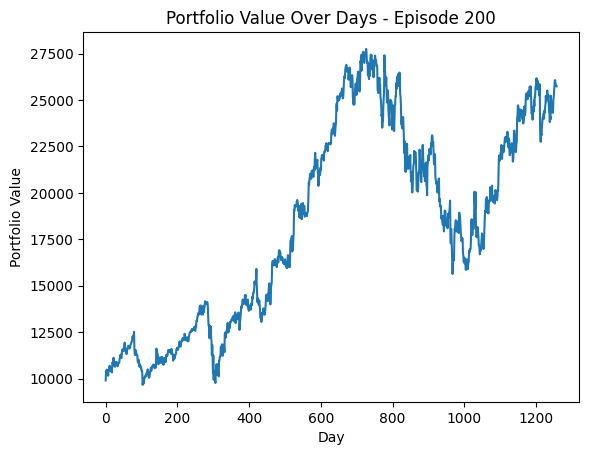

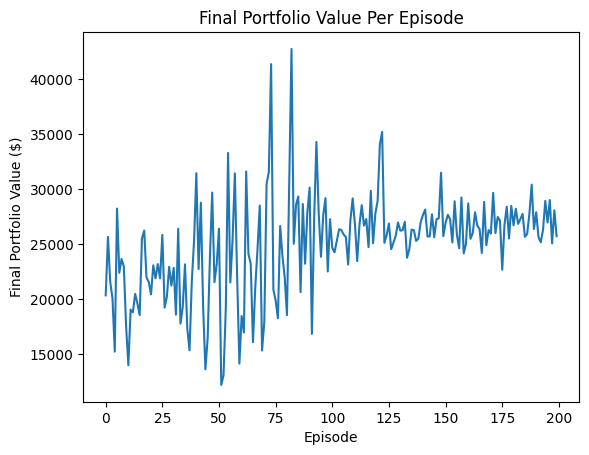

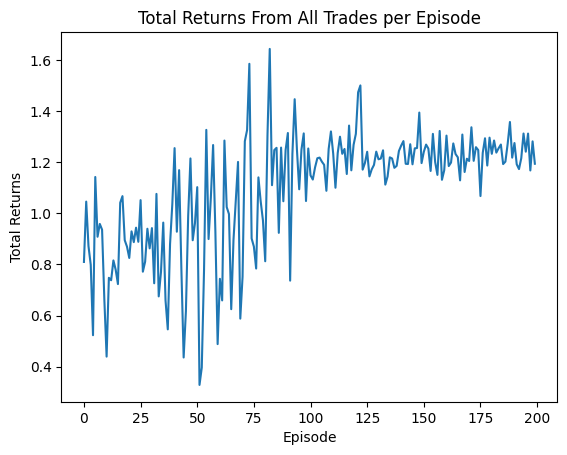

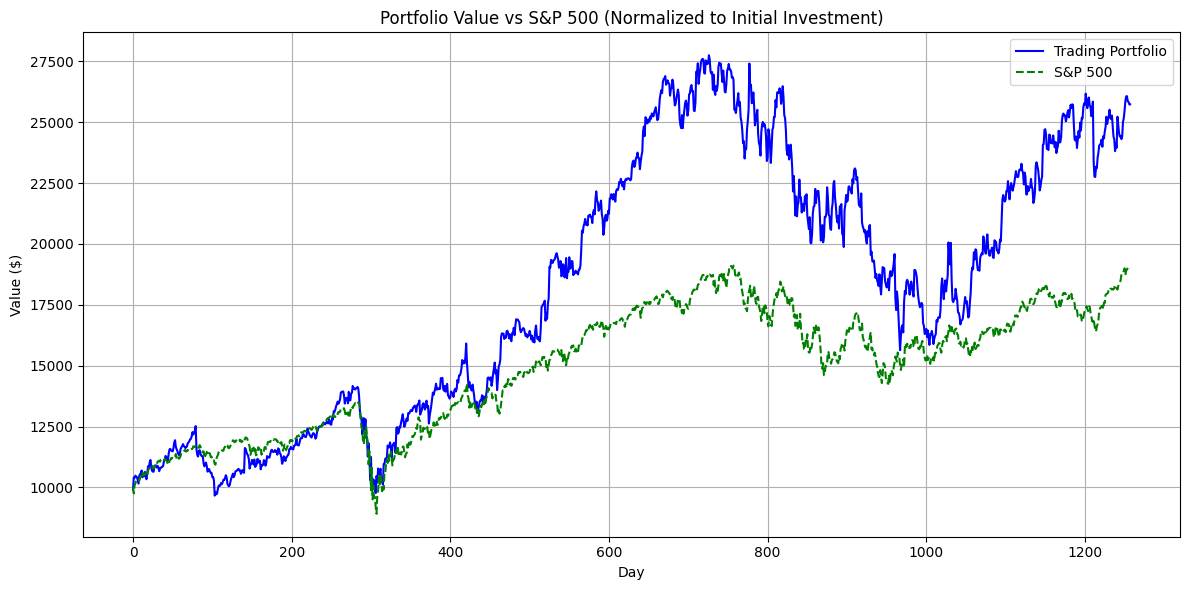

In [23]:
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))
# Assuming other parts of your code remain the same

fetch_snp500_data()  # Load S&P 500 data at startup

def plot_portfolio_vs_snp500(portfolio_values, initial_cash=10000):
    """Plot portfolio values against S&P 500 performance"""
    snp_close = get_close_prices()
    
    if snp_close is None:
        print("Could not load S&P 500 data")
        return
    
    # Ensure same length
    min_len = min(len(portfolio_values), len(snp_close))
    portfolio_values = portfolio_values[:min_len]
    snp_close = snp_close[:min_len]
    
    # Normalize S&P 500 to match initial portfolio value
    snp_normalized = (snp_close / snp_close[0]) * initial_cash
    
    plt.figure(figsize=(12, 6))
    plt.plot(portfolio_values, label='Trading Portfolio', color='blue')
    plt.plot(snp_normalized, label='S&P 500', color='green', linestyle='--')
    plt.xlabel('Day')
    plt.ylabel('Value ($)')
    plt.title('Portfolio Value vs S&P 500 (Normalized to Initial Investment)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Configuration
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tickers = ["AAPL", "MSFT", "AMZN", "GOOGL", "META", "JPM", "JNJ", "V", "PG", "MA",
               "NVDA", "UNH", "HD", "DIS", "BAC", "PFE", "CMCSA", "VZ", "ADBE", "NFLX"]
    
    # Download data
    print("Downloading stock data...")
    data = yf.download(tickers, start="2019-01-01", end="2023-12-31")["Close"]
    data = data.fillna(method='ffill').fillna(method='bfill')
    stock_prices = data.values.astype(np.float32)
    
    # Create environment
    env = TradingEnv(stock_prices)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    
    # Initialize agent and replay buffer
    agent = CQLAgent(state_dim, action_dim, device, alpha=0.5, num_samples=10)
    replay_buffer = ReplayBuffer(100000)
    
    # Training parameters
    num_episodes = 200
    batch_size = 128

    min_epsilon = 0.01
    max_epsilon = 0.95

    # Inside the main training loop:
    returns = []
    portfolio_values_per_episode = []
    last_episode_portfolio_values = []  # List to store portfolio value over each day in the last episode
    cumulative_returns = []  # List to track cumulative returns

    step_count = 0  # Global step counter
    decay_steps = 100
    decay_amount = (max_epsilon - min_epsilon) / decay_steps

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        episode_return = 0
        episode_portfolio_values = []
        cumulative_return = 0  # Initialize cumulative return for the episode

        # Decay epsilon over first 100 steps
        epsilon = max(min_epsilon, max_epsilon  - (step_count * decay_amount))
        step_count += 1      

        while not done:
            action = agent.select_action(state, epsilon)
            next_state, reward, done, _ = env.step(action)
            replay_buffer.push(state, action, reward, next_state, done)
            state = next_state
            episode_return += reward

            # Store portfolio value for each day
            episode_portfolio_values.append(env.get_portfolio_value())

            # Update agent
            agent.update(replay_buffer, batch_size)

        returns.append(episode_return)
        portfolio_values_per_episode.append(env.get_portfolio_value())

        # Store portfolio values for the last episode
        if episode == num_episodes - 1:
            last_episode_portfolio_values = episode_portfolio_values

        # Calculate cumulative return (as percentage)
        cumulative_return = (env.get_portfolio_value() - env.initial_portfolio_value) / env.initial_portfolio_value * 100
        cumulative_returns.append(cumulative_return)

        # Get portfolio value in dollars
        portfolio_value = env.get_portfolio_value()

        print(f"Episode {episode+1}/{num_episodes}, Return: {episode_return:.2f}, "
              f"Cumulative Return: {cumulative_return:.2f}%, Portfolio Value: ${portfolio_value:.2f}, Epsilon: {epsilon:.3f}")



    # After training, plot the portfolio value for the last episode
    plt.plot(last_episode_portfolio_values)
    plt.xlabel("Day")
    plt.ylabel("Portfolio Value")
    plt.title(f"Portfolio Value Over Days - Episode {num_episodes}")
    plt.show()
    
    # Plot portfolio value per episode
    plt.plot(portfolio_values_per_episode)
    plt.xlabel("Episode")
    plt.ylabel("Final Portfolio Value ($)")
    plt.title("Final Portfolio Value Per Episode")
    plt.show()
    
    plt.plot(returns)
    plt.xlabel("Episode")
    plt.ylabel("Total Returns")
    plt.title("Total Returns From All Trades per Episode")
    plt.show()

    plot_portfolio_vs_snp500(last_episode_portfolio_values, env.initial_cash)


## **Naive DQN**

In [1]:
import numpy as np
import gym
from gym import spaces
from collections import namedtuple

class TradingEnvDiscrete(gym.Env):
    def __init__(self, stock_prices, initial_cash=10000, discrete_actions=None):
        super().__init__()
        self.stock_prices = stock_prices  # shape: (T, num_stocks)
        self.initial_cash = initial_cash
        self.num_stocks = stock_prices.shape[1]
        self.current_step = 0

        # Define discrete actions as a list of allocation vectors.
        # If no discrete_actions are provided, use a default set:
        #  - Equal allocation among all stocks.
        #  - "All-in" allocation for each stock.
        if discrete_actions is None:
            self.discrete_actions = []
            # Equal allocation (baseline)
            self.discrete_actions.append(np.full(self.num_stocks, 1.0 / self.num_stocks))
            # All-in allocations (choose one stock to allocate 100% to)
            for i in range(self.num_stocks):
                action = np.zeros(self.num_stocks, dtype=np.float32)
                action[i] = 1.0
                self.discrete_actions.append(action)
        else:
            self.discrete_actions = discrete_actions

        # Set discrete action space with number of available actions.
        self.action_space = spaces.Discrete(len(self.discrete_actions))

        # Observation: concatenation of current prices and current holdings.
        obs_low = np.zeros(self.num_stocks * 2, dtype=np.float32)
        obs_high = np.full(self.num_stocks * 2, np.inf, dtype=np.float32)
        self.observation_space = spaces.Box(low=obs_low, high=obs_high, dtype=np.float32)

    def reset(self):
        self.current_step = 0
        current_prices = self.stock_prices[self.current_step]

        # Start with equal allocation using initial cash.
        allocation = np.full(self.num_stocks, 1.0 / self.num_stocks)
        self.cash = self.initial_cash
        self.holdings = (allocation * self.cash) / current_prices
        self.cash = 0.0  # All cash is used to buy stocks

        self.cost_basis = current_prices.copy()
        self.sold_profit = 0.0
        self.prev_portfolio_value = np.sum(self.holdings * current_prices)

        # Store initial portfolio value for total return calculation
        self.initial_portfolio_value = self.prev_portfolio_value

        return np.concatenate([current_prices, self.holdings])
   
    def _get_obs(self):
        current_prices = self.stock_prices[self.current_step]
        return np.concatenate([current_prices, self.holdings])
   
    def step(self, action_index):
        current_prices = self.stock_prices[self.current_step]
        portfolio_value = self.cash + np.sum(self.holdings * current_prices)

        # Get allocation vector from our discrete set
        allocation = self.discrete_actions[action_index]

        # Compute target portfolio values and shares based on the selected allocation
        target_value = portfolio_value * allocation
        target_shares = target_value / current_prices

        # Rebalance portfolio while ensuring no negative holdings.
        for i in range(self.num_stocks):
            delta = target_shares[i] - self.holdings[i]
            if delta < 0:  # Sell shares
                shares_to_sell = min(-delta, self.holdings[i])
                sale_amount = shares_to_sell * current_prices[i]
                realized_profit = (current_prices[i] - self.cost_basis[i]) * shares_to_sell
                self.holdings[i] -= shares_to_sell
                self.cash += sale_amount
                self.sold_profit += realized_profit
            elif delta > 0:  # Buy shares if cash available
                cost = delta * current_prices[i]
                if cost > self.cash:
                    delta = self.cash / current_prices[i]
                    cost = delta * current_prices[i]
                if self.holdings[i] > 0:
                    self.cost_basis[i] = ((self.cost_basis[i] * self.holdings[i]) + (current_prices[i] * delta)) / (self.holdings[i] + delta)
                else:
                    self.cost_basis[i] = current_prices[i]
                self.holdings[i] += delta
                self.cash -= cost

        # Compute new portfolio value
        portfolio_value = self.cash + np.sum(self.holdings * current_prices)

        # Reward is the percentage increase from previous step portfolio value.
        reward = (portfolio_value - self.prev_portfolio_value) / self.prev_portfolio_value if self.prev_portfolio_value > 0 else 0
        self.prev_portfolio_value = portfolio_value

        self.current_step += 1
        done = self.current_step >= len(self.stock_prices)
        obs = self._get_obs() if not done else np.concatenate([self.stock_prices[-1], self.holdings])

        return obs, reward, done, {}

    def render(self, mode="human"):
        current_prices = self.stock_prices[self.current_step - 1]
        portfolio_value = self.cash + np.sum(self.holdings * current_prices)
        print(f"Day {self.current_step} - Portfolio Value: ${portfolio_value:.2f}, Cash: ${self.cash:.2f}")

    def get_portfolio_value(self):
        # Ensure current_step is within bounds
        if self.current_step < len(self.stock_prices):
            return self.cash + np.sum(self.holdings * self.stock_prices[self.current_step])
        else:
            return self.cash + np.sum(self.holdings * self.stock_prices[-1])
        
    def get_total_return(self):
        final_portfolio_value = self.cash + np.sum(self.holdings * self.stock_prices[min(self.current_step, len(self.stock_prices)-1)])
        total_return = (final_portfolio_value - self.initial_portfolio_value) / self.initial_portfolio_value * 100
        return total_return

# For storing transitions later if needed
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))


In [2]:
import gymnasium as gym
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple, deque
from itertools import count
import os
import yfinance as yf

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transition tuple
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

# Implement replay memory from lecture
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

class NaiveDQNAgent:
    def __init__(self, env, batch_size=128, gamma=0.9, eps_start=0.9, eps_end=0.05, eps_decay=100, lr=1e-3, initial_portfolio_value=10000):
        self.env = env
        self.batch_size = batch_size
        self.gamma = gamma
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay
        self.lr = lr
        self.steps_done = 0
        self.initial_portfolio_value = initial_portfolio_value
        self.portfolio_value = initial_portfolio_value
        self.cumulative_return = 0

        # Number of observations and actions
        n_observations = 2 * env.num_stocks  # stock prices + holdings
        n_actions = len(env.discrete_actions)

        self.policy_net = DQN(n_observations, n_actions).to(device)
        self.target_net = DQN(n_observations, n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)
        self.memory = ReplayMemory(10000)

    def select_action(self, state):
        sample = random.random()
        
        # Update epsilon decay properly
        epsilon = self.eps_end + (self.eps_start - self.eps_end) * math.exp(-1. * self.steps_done / self.eps_decay)
        self.steps_done += 1  # Ensure that steps_done is incremented after each action

        # Convert state to a tensor
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).view(1, -1)
        
        if sample > epsilon:
            with torch.no_grad():
                return self.policy_net(state_tensor).max(1).indices.view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.env.action_space.n)]], device=device, dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return

        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)

        non_final_next_states = torch.cat([
            torch.tensor(s, dtype=torch.float32, device=device).view(1, -1) for s in batch.next_state if s is not None
        ])

        state_batch = torch.cat([
            torch.tensor(s, dtype=torch.float32, device=device).view(1, -1) for s in batch.state
        ])

        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(self.batch_size, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1).values
        expected_state_action_values = (next_state_values * self.gamma) + reward_batch

        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def train(self, num_episodes, target_update=10, rolling_window=1000):
        total_rewards = np.zeros(num_episodes)
        running_avg_rewards = np.zeros(num_episodes)

        for i_episode in range(num_episodes):
            state = self.env.reset()
            episode_return = 0
            portfolio_value = self.initial_portfolio_value
            self.portfolio_value = portfolio_value  # Reset portfolio value
            self.cumulative_return = 0
            initial_portfolio_value = portfolio_value

            for t in count():
                action = self.select_action(state)
                next_state, reward, done, _ = self.env.step(action.item())
                
                # Update portfolio value based on action and reward
                portfolio_value += reward  # Assuming reward is the profit/loss from the action
                episode_return = (portfolio_value - initial_portfolio_value) / initial_portfolio_value * 100  # Calculate return as % change
                
                total_rewards[i_episode] += reward
                self.cumulative_return = (portfolio_value - self.initial_portfolio_value) / self.initial_portfolio_value * 100
                
                reward_tensor = torch.tensor([reward], dtype=torch.float32, device=device)

                if not done:
                    next_state_tensor = torch.tensor(next_state, dtype=torch.float32, device=device).view(1, -1)
                else:
                    next_state_tensor = None
                self.memory.push(state, action, next_state_tensor, reward_tensor)
                state = next_state if next_state_tensor is not None else state
                self.optimize_model()
                if done:
                    break

            # Log the episode results in the desired format
            print(f"Episode {i_episode+1}/{num_episodes}, "
                  f"Return: {episode_return:.2f}, "
                  f"Cumulative Return: {self.cumulative_return:.2f}%, "
                  f"Portfolio Value: ${portfolio_value:.2f}, "
                  f"Epsilon: {self.eps_start + (self.eps_end - self.eps_start) * math.exp(-1. * self.steps_done / self.eps_decay):.3f}")

            # Calculate rolling average over the last 1000 episodes
            start_idx = max(0, i_episode - rolling_window + 1)
            running_avg_rewards[i_episode] = np.mean(total_rewards[start_idx:i_episode + 1])

            if i_episode % target_update == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

        return running_avg_rewards

In [3]:
if __name__ == "__main__":
    tickers = [
        "AAPL", "MSFT", "AMZN", "GOOGL", "META",
        "JPM", "JNJ", "V", "PG", "MA",
        "NVDA", "UNH", "HD", "DIS", "BAC",
        "PFE", "CMCSA", "VZ", "ADBE", "NFLX"
    ]

    print("Downloading stock data...")
    data = yf.download(tickers, start="2015-01-01", end="2022-12-31")["Close"]
    data = data.fillna(method='ffill').fillna(method='bfill')
    stock_prices = data.values.astype(np.float32)

    env = TradingEnvDiscrete(stock_prices)
    agent = NaiveDQNAgent(env)

    print("Training agent...")
    running_avg_rewards = agent.train(num_episodes=200)
    
    plt.plot(running_avg_rewards)
    plt.xlabel('Episodes')
    plt.ylabel('Running Average Reward')
    plt.title('DQN Training Progress')
    plt.show()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  20 of 20 completed
/scratch/3697655.1.l40s/ipykernel_377600/2223350851.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').fillna(method='bfill')


RuntimeError: CUDA error: CUDA-capable device(s) is/are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
